In [796]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from scipy.optimize import minimize
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error

In [797]:
# Reading data from CSV file 
shb = pd.read_csv("c:/dh/Phan tich DLKD/Dataset/SHB.VN-1.csv")

In [798]:
# Convert the time column to datetime
shb['Date'] = pd.to_datetime(shb['Date'])

# Select column 'Close' as the dependent variable
shb_Close = shb[['Date', 'Close']]

# Reset the index of the DataFrame
shb_Close = shb_Close.reset_index(drop=True)

In [799]:
# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
shb_Close['Close'] = scaler.fit_transform(np.array(shb_Close['Close']).reshape(-1, 1))

# Split train, test set
train_size = int(0.6 * len(shb_Close))
test_size = len(shb_Close) - train_size

train_data = shb_Close[:train_size]
test_data = shb_Close[train_size:]

In [800]:
# Function to create dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Reshape data
time_step = 100
X_train, y_train = create_dataset(train_data[['Close']].values, time_step)
X_test, y_test = create_dataset(test_data[['Close']].values, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [801]:
# Prepare data for SEMOS
data = shb_Close.set_index('Date')
data['LogPrice'] = np.log(data['Close'] + 1)  # Add 1 to avoid log(0)

In [802]:
# Split data into train and test sets
train_data = data[:train_size]
test_data = data[train_size:]

In [803]:
# Fourier series function
def fourier_series(t, n=4):
    t = np.atleast_1d(t)
    result = []
    for i in range(1, n + 1):
        result.append(np.sin(2 * np.pi * i * t / 365.25))
        result.append(np.cos(2 * np.pi * i * t / 365.25))
    return np.vstack(result).T

In [804]:
# SEMOS prediction function
def semos_predict(params, x, t):
    a0, a1, b0, b1 = params[:4]
    alpha = params[4:8]
    beta = params[8:12]

    seasonal_effects = np.dot(fourier_series(t, 4), np.hstack((alpha, beta)))

    # Ensure x is an array, even if it's a single value
    x = np.atleast_1d(x)
    mu_t = a0 + a1 * x[0] + seasonal_effects[0]

    log_sigma_t = b0 + b1 * np.log(np.std(x) + 1e-8)
    if len(seasonal_effects) > 1:
        log_sigma_t += seasonal_effects[1]
    log_sigma_t = np.clip(log_sigma_t, -10, 10)  # Clip log_sigma_t to avoid overflow

    return mu_t, np.exp(log_sigma_t)

In [805]:
# SEMOS parameter estimation function
def estimate_semos_params(data):
    def objective(params):
        mu_t, sigma_t = semos_predict(params, data['LogPrice'].values, data.index.dayofyear.values)
        residuals = data['LogPrice'].values - mu_t
        return -np.sum(norm.logpdf(residuals, scale=sigma_t))

    initial_params = np.random.rand(12)
    result = minimize(objective, initial_params, method='L-BFGS-B')
    return result.x

In [806]:
# Autoregressive model for residuals
def autoregressive_model(residuals, lags=5):
    model = AutoReg(residuals, lags=lags)
    model_fit = model.fit()
    return model_fit

In [807]:
# Train SEMOS model
params = estimate_semos_params(train_data)
mu_t, sigma_t = semos_predict(params, train_data['LogPrice'].values, train_data.index.dayofyear.values)
residuals = train_data['LogPrice'].values - mu_t

In [808]:
# Train AR model for residuals
ar_model = autoregressive_model(residuals)

In [809]:
# Predict future stock prices
def predict_future_prices(data, params, steps=10):
    last_log_price = data['LogPrice'].values[-1]
    future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=steps)
    predictions = []

    for i, date in enumerate(future_dates):
        day_of_year = date.dayofyear
        mu_t, sigma_t = semos_predict(params, last_log_price, day_of_year)
        future_log_price = mu_t  # Only use SEMOS value without adding AR
        predictions.append(np.exp(future_log_price) - 1)
        last_log_price = future_log_price

    return pd.Series(predictions, index=future_dates)

In [810]:
# Make predictions on the test set
mu_t_test, sigma_t_test = semos_predict(params, test_data['LogPrice'].values, test_data.index.dayofyear.values)
residuals_test = test_data['LogPrice'].values - mu_t_test
ar_model_test = autoregressive_model(residuals_test)

In [811]:
# Predict stock prices for the next 30, 60, 90 days using SEMOS only
predictions_30_days = predict_future_prices(test_data, params, steps=30)
predictions_60_days = predict_future_prices(test_data, params, steps=60)
predictions_90_days = predict_future_prices(test_data, params, steps=90)

In [812]:
# Calculate metrics
y_test_inv = scaler.inverse_transform(test_data[['Close']].values)
predicted_test_prices = np.exp(mu_t_test) - 1
predicted_test_prices_inv = scaler.inverse_transform(predicted_test_prices.reshape(-1, 1))

In [813]:
# Ensure consistent lengths for MAPE calculation
y_test_inv = y_test_inv[:len(predicted_test_prices_inv)]

# Calculate MAPE for test set
test_MAPE = mean_absolute_percentage_error(y_test_inv, predicted_test_prices_inv)

# Calculate RMSE for test set
test_RMSE = mean_squared_error(y_test_inv, predicted_test_prices_inv, squared=False)

# Calculate MSLE for test set
test_MSLE = mean_squared_log_error(y_test_inv, predicted_test_prices_inv)

print('Test MAPE:', test_MAPE)
print('Test RMSE:', test_RMSE)
print('Test MSLE:', test_MSLE)

Test MAPE: 6.336322017072225
Test RMSE: 101091.64920517268
Test MSLE: 3.97118606209901


In [814]:
# Create new prediction date ranges
last_index_date = shb_Close['Date'].iloc[-1]
predict_dates_30 = pd.date_range(start=last_index_date + pd.Timedelta(days=1), periods=30)
predict_dates_60 = pd.date_range(start=last_index_date + pd.Timedelta(days=1), periods=60)
predict_dates_90 = pd.date_range(start=last_index_date + pd.Timedelta(days=1), periods=90)

In [815]:
# Inverse transform predictions
predictions_30_days_inv = scaler.inverse_transform(predictions_30_days.values.reshape(-1, 1))
predictions_60_days_inv = scaler.inverse_transform(predictions_60_days.values.reshape(-1, 1))
predictions_90_days_inv = scaler.inverse_transform(predictions_90_days.values.reshape(-1, 1))

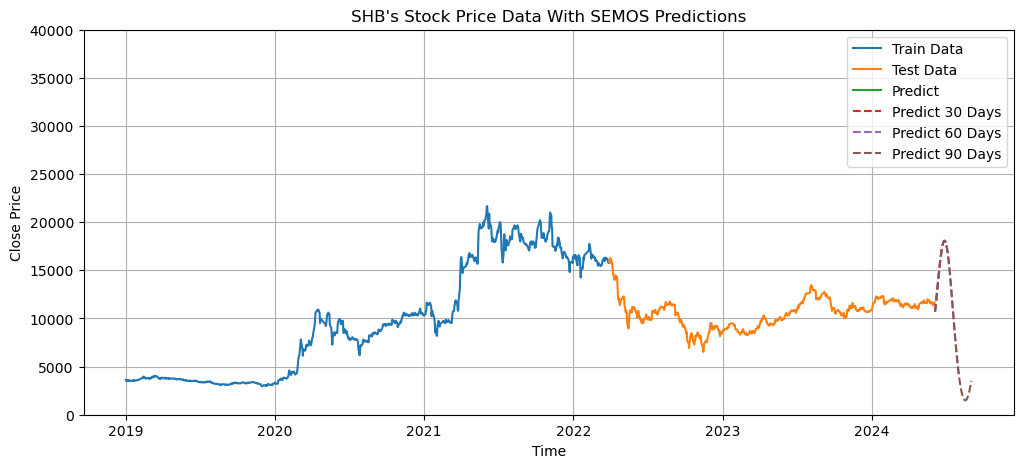

In [824]:
# Plotting
plt.figure(figsize=(12, 5))

plt.plot(shb_Close['Date'][:train_size], scaler.inverse_transform(data[['Close']][:train_size]), label='Train Data')
plt.plot(shb_Close['Date'][train_size:], scaler.inverse_transform(data[['Close']][train_size:]), label='Test Data')
plt.plot(shb_Close['Date'][train_size:train_size + len(predicted_test_prices_inv)], predicted_test_prices_inv, label='Predict')

plt.plot(predictions_30_days.index, predictions_30_days_inv, linestyle='dashed', label='Predict 30 Days')
plt.plot(predictions_60_days.index, predictions_60_days_inv, linestyle='dashed', label='Predict 60 Days')
plt.plot(predictions_90_days.index, predictions_90_days_inv, linestyle='dashed', label='Predict 90 Days')

plt.title("SHB's Stock Price Data With SEMOS Predictions")
plt.xlabel('Time')
plt.ylabel('Close Price')

# Set y-axis limit
plt.ylim(0, 40000)

plt.legend(['Train Data', 'Test Data', 'Predict', 'Predict 30 Days', 'Predict 60 Days', 'Predict 90 Days'])
plt.grid(True)
plt.show()